In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import importlib
import rfm_q
importlib.reload(rfm_q)  # Reload the updated module
from rfm_q import q_rfm



In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer



[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator')]


In [55]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

In [56]:
# set data path
def set_data_path():
    return "../data/"
#     raise NotImplementedError

In [57]:
def pre_process(torchset,n_samples,num_classes=10):
    indices = list(np.random.choice(len(torchset),n_samples))

    trainset = []
    for ix in indices:
        x,y = torchset[ix]
        ohe_y = torch.zeros(num_classes)
        ohe_y[y] = 1
        trainset.append(((x/np.linalg.norm(x)).reshape(-1),ohe_y))
    return trainset

In [58]:
# load svhn data
transform = transforms.Compose([
    transforms.ToTensor()
])

data_path = set_data_path() ## set this data path

trainset0 = torchvision.datasets.SVHN(root=data_path,
                                    split = "train",
                                    transform=transform,
                                    download=True)
testset0 = torchvision.datasets.SVHN(root=data_path,
                                    split = "test",
                                    transform=transform,
                                    download=True)

trainset = pre_process(trainset0,n_samples=5000, num_classes=10)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)


testset = pre_process(testset0,n_samples=5000, num_classes=10)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)



Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [59]:
# rfm import 
from rfm import *

In [61]:
import importlib
import rfm_q
importlib.reload(rfm_q)
from rfm_q import q_rfm


In [62]:
import qiskit


In [116]:
train_data = scipy.io.loadmat('/data/yi/recursive_feature_machines_1/example_notebooks/data/4x4MNIST_Train&Test/4x4MNIST_Train&Test/MNIST_Train_Nox16.mat')
test_data = scipy.io.loadmat('/data/yi/recursive_feature_machines_1/example_notebooks/data/4x4MNIST_Train&Test/4x4MNIST_Train&Test/MNIST_Test_Nox16.mat')

X_train = train_data['VV'][:500]
X_test = test_data['UU'][:100]

print(X_train.shape)
print(X_test.shape)

(500, 16)
(100, 16)


In [117]:
import csv

# Initialize an empty list to store the first column values.
y_train = []
y_test = []
# Specify your CSV file path.
csv_file_path1 = '/data/yi/recursive_feature_machines_1/example_notebooks/data/4x4MNIST_Train&Test/mnist_train.csv'
csv_file_path2 = '/data/yi/recursive_feature_machines_1/example_notebooks/data/4x4MNIST_Train&Test/mnist_test.csv'
# Open the CSV file in read mode.
with open(csv_file_path1, newline='', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    
    # Iterate over each row in the CSV file.
    for row in csvreader:
        if row:  # Ensure the row is not empty.
            # Append the first column (index 0) to the list.
            y_train.append(int(row[0]))

with open(csv_file_path2, newline='', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    
    # Iterate over each row in the CSV file.
    for row in csvreader:
        if row:  # Ensure the row is not empty.
            # Append the first column (index 0) to the list.
            y_test.append(int(row[0]))

num_classes = 10
y_train = np.eye(num_classes)[y_train[:500]]
y_test = np.eye(num_classes)[y_test[:100]]
# Final debug print showing all the data collected from the first column.
print(y_train.shape)
print(y_test.shape)

(500, 10)
(100, 10)


In [ ]:
# %% [code]
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import hickle
from numpy.linalg import solve
import time

# Qiskit imports for the quantum kernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import Aer
from qiskit_machine_learning.kernels import FidelityQuantumKernel
import os
os.environ['OMP_NUM_THREADS'] = '60'

# Dummy get_data function (assumes a DataLoader input)
def get_data(loader):
    X_list, y_list = [], []
    for batch in loader:
        inputs, labels = batch
        X_list.append(inputs)
        y_list.append(labels)
    X = torch.cat(X_list, dim=0)
    y = torch.cat(y_list, dim=0)
    return X, y

# The quantum kernel matrix helper function.
def encode_features(X):
    """Scales each column of X to [0, 1] then multiplies by pi."""
    X = X.copy().astype(np.float64)  # ensure float type
    for j in range(X.shape[1]):
        col_min = X[:, j].min()
        col_max = X[:, j].max()
        if abs(col_max - col_min) < 1e-12:
            X[:, j] = 0.0
        else:
            X[:, j] = (X[:, j] - col_min) / (col_max - col_min)
    X *= np.pi
    return X

def quantum_kernel_matrix(X1, X2, q_kernel, M=None, do_encode=True):
    """
    Evaluates the quantum kernel matrix for inputs X1 and X2.
    Applies optional encoding and a linear transformation via M.
    """
    if isinstance(X1, torch.Tensor):
        X1 = X1.cpu().numpy()
    if isinstance(X2, torch.Tensor):
        X2 = X2.cpu().numpy()

    if do_encode:
        X1 = encode_features(X1)
        X2 = encode_features(X2)

    if M is not None:
        sqrtM = np.real_if_close(np.linalg.cholesky(M))
        X1 = X1 @ sqrtM
        X2 = X2 @ sqrtM

    print("[DEBUG] Evaluating Quantum Kernel...")
    start_time = time.time()
    K = q_kernel.evaluate(x_vec=X1, y_vec=X2)
    end_time = time.time()
    print(f"[DEBUG] Kernel evaluated: shape {K.shape}, time {end_time - start_time:.2f} s")
    return K

def quantum_laplacian_M(samples, centers, bandwidth, M, q_kernel, do_encode=True):
    """
    Computes a Laplacian-style quantum kernel matrix.
    """
    assert bandwidth > 0, "Bandwidth must be > 0."
    print("[DEBUG] Evaluating quantum kernel fidelity matrix...")
    kernel_mat = quantum_kernel_matrix(samples, centers, q_kernel, M=M, do_encode=do_encode)
    quantum_distance = 1 - kernel_mat
    quantum_distance = np.maximum(quantum_distance, 0)
    print("[DEBUG] Quantum distance matrix computed (1 - fidelity).")
    gamma = 1.0 / bandwidth
    print(f"[DEBUG] Applying Laplacian transformation with gamma = {gamma:.4f}...")
    laplacian_kernel = np.exp(-gamma * quantum_distance)
    print("[DEBUG] Laplacian quantum kernel matrix computed.")
    return laplacian_kernel

def q_rfm(train_loader, test_loader,
          iters=3, name=None, batch_size=2, reg=1e-3,
          train_acc=False, loader=True, classif=True):
    print("[DEBUG] Entered q_rfm function...")
    """
    Quantum version of the Recursive Feature Machine.
    """
    # Use dummy training data to set the feature dimension
    X_train_dummy, _ = get_data(train_loader) if loader else train_loader
    feature_dim = X_train_dummy.shape[1]
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement="full")
    print("[DEBUG] Initializing Aer backend...")
    backend = AerSimulator(method='statevector', max_parallel_threads=60)
    print("[DEBUG] Aer backend initialized successfully")
    
    print("[DEBUG] Creating FidelityQuantumKernel...")
    q_kernel = FidelityQuantumKernel(feature_map=feature_map)
    print("[DEBUG] FidelityQuantumKernel created successfully")
    
    # Quick test kernel evaluation with small random data
    X_test_eval = np.random.rand(10, feature_dim)
    K_test_eval = q_kernel.evaluate(x_vec=X_test_eval, y_vec=X_test_eval)
    print("[DEBUG] Kernel Evaluation Success! Matrix shape:", K_test_eval.shape)
    
    L = 10

    if loader:
        print("[DEBUG] Loaders provided")
        X_train, y_train = get_data(train_loader)
        X_test, y_test = get_data(test_loader)
    else:
        print("[DEBUG] Loaders not used, loading manually")
        X_train, y_train = train_loader
        X_test, y_test = test_loader
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        y_train = torch.from_numpy(y_train).float()
        y_test = torch.from_numpy(y_test).float()
    
    print(f"[DEBUG] X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"[DEBUG] X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    feature_dim = X_train.shape[1]
    feature_map.feature_dimension = feature_dim
    
    n, d = X_train.shape
    # Start with an identity matrix M for the recursive update.
    M = np.eye(d, dtype='float32')
    
    for i in range(iters):
        print(f"[DEBUG] Iteration {i+1}/{iters} started...")
        print("[DEBUG] Computing K_train...")
        K_train = quantum_kernel_matrix(X_train, X_train, q_kernel)
        print(f"[DEBUG] K_train computed, shape: {K_train.shape}")
        sol = solve(K_train + reg * np.eye(len(K_train)), y_train.numpy()).T
        
        if train_acc:
            preds = (sol @ K_train).T
            y_pred = torch.from_numpy(preds)
            preds_class = torch.argmax(y_pred, dim=-1)
            labels = torch.argmax(y_train, dim=-1)
            count = torch.sum(labels == preds_class).numpy()
            print("Round " + str(i) + " Train Acc: ", count / len(labels))
        
        K_test = quantum_kernel_matrix(X_train, X_test, q_kernel)
        preds = (sol @ K_test).T
        mse = np.mean(np.square(preds - y_test.numpy()))
        print("Round " + str(i) + " MSE: ", mse)
        
        if classif:
            y_pred = torch.from_numpy(preds)
            preds_class = torch.argmax(y_pred, dim=-1)
            labels = torch.argmax(y_test, dim=-1)
            count = torch.sum(labels == preds_class).numpy()
            print("Round " + str(i) + " Acc: ", count / len(labels))
        
        print("[DEBUG] Calling get_grads... (skipped in this dummy demo)")
        # For demonstration, we'll skip the recursive update.
        # M = get_grads(X_train, sol, L, torch.from_numpy(M), q_kernel, batch_size=batch_size)
        print("[DEBUG] get_grads skipped")
    
    K_train = quantum_kernel_matrix(X_train, X_train, q_kernel)
    print("[DEBUG] Solving system of equations...")
    sol = solve(K_train + reg * np.eye(len(K_train)), y_train.numpy()).T
    print("[DEBUG] System solved")
    K_test = quantum_kernel_matrix(X_train, X_test, q_kernel)
    preds = (sol @ K_test).T
    mse = np.mean(np.square(preds - y_test.numpy()))
    print("Final MSE: ", mse)
    
    if classif:
        y_pred = torch.from_numpy(preds)
        preds_class = torch.argmax(y_pred, dim=-1)
        labels = torch.argmax(y_test, dim=-1)
        count = torch.sum(labels == preds_class).numpy()
        print("Final Acc: ", count / len(labels))
    return M, mse

# -------------------------------
# Create Dummy Data for Classification
# -------------------------------

# Settings for dummy data:
num_train = 100
num_test = 20
num_features = 8
num_classes = 3

# # Random input features
# X_train_dummy = np.random.rand(num_train, num_features).astype(np.float32)
# X_test_dummy = np.random.rand(num_test, num_features).astype(np.float32)

# # Random labels: one-hot encoded for 3 classes.
# y_train_dummy = np.eye(num_classes)[np.random.randint(0, num_classes, size=num_train)]
# y_test_dummy = np.eye(num_classes)[np.random.randint(0, num_classes, size=num_test)]

# Convert to torch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders.
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Run q_rfm on dummy data to test MSE and accuracy.
M_final, mse_final = q_rfm(train_loader, test_loader, iters=2, loader=True, classif=True, train_acc=True)
print("Final MSE from q_rfm on 4x4 data:", mse_final)


[DEBUG] Entered q_rfm function...
[DEBUG] Initializing Aer backend...
[DEBUG] Aer backend initialized successfully
[DEBUG] Creating FidelityQuantumKernel...
[DEBUG] FidelityQuantumKernel created successfully
[DEBUG] Kernel Evaluation Success! Matrix shape: (10, 10)
[DEBUG] Loaders provided
[DEBUG] X_train shape: torch.Size([500, 16]), y_train shape: torch.Size([500, 10])
[DEBUG] X_test shape: torch.Size([100, 16]), y_test shape: torch.Size([100, 10])
[DEBUG] Iteration 1/2 started...
[DEBUG] Computing K_train...
[DEBUG] Evaluating Quantum Kernel...


We have run three steps of RFM (the first iterate is the original laplace kernel), returning the M matrix of the final iterate.

In [43]:
# visualize M matrix
import matplotlib.pyplot as plt
%matplotlib inline

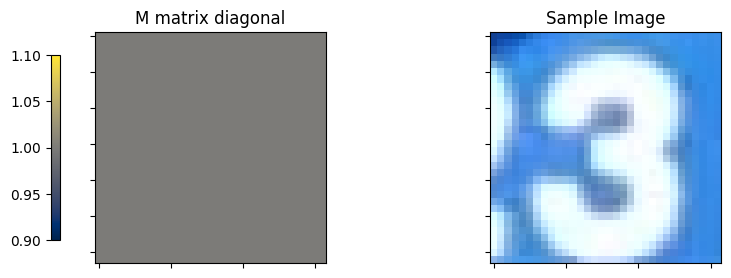

In [44]:
f, axarr = plt.subplots(1,2,figsize=(10, 3))
axarr[0].axes.xaxis.set_ticklabels([])
axarr[0].axes.yaxis.set_ticklabels([])
axarr[1].axes.xaxis.set_ticklabels([])
axarr[1].axes.yaxis.set_ticklabels([])

pcm = axarr[0].imshow(np.mean(np.diag(M).reshape(3,32,32),axis=0),cmap='cividis')
axarr[0].set_title("M matrix diagonal")
f.colorbar(mappable=pcm, ax=axarr[0], shrink=0.8,location="left")
axarr[1].imshow(torch.moveaxis(trainset0[3][0],0,2))
axarr[1].set_title("Sample Image")
print()

Here we plot the diagonal (averaged across channels) of the M matrix to see which coordinates are being highlighted by RFM. The center of the image is highlighted (where the digits appear). 